In [1]:

# Bring masking back -> also for prediction
# Prepend sth for the Sequences to start 


#http://nlp.seas.harvard.edu/2018/04/03/attention.html
#https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
#https://keras.io/guides/understanding_masking_and_padding/

#### OK 
# Remove high dim embeddings and add positional encoding directly to data for 1D input 
# Added actual positional embeddings
# Global model_dim 

In [2]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import matplotlib.pyplot as plt
import math 

from Helpers import create_rolling_windows 

In [3]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="Head2Eye", entity="sballe")

wandb: Currently logged in as: sballe (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Dataset

Surrogate data: Some sinusoidals that depend on each other. 
Create windows of length 'sequence_length', where input sequence is exactly that long and target sequence has prepended 0 as start symbol.

In [4]:
batch_size = 64
sequence_length = 200

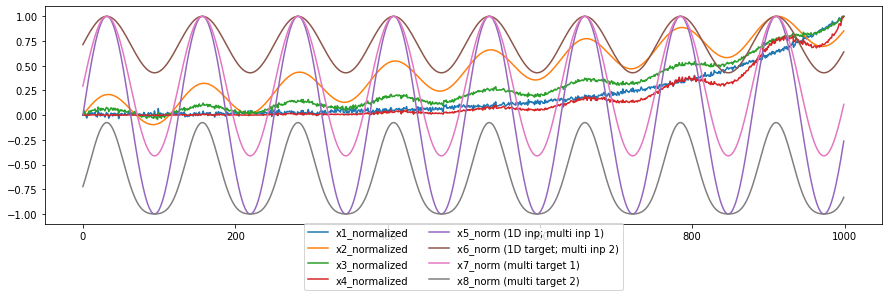

In [5]:
# Create surrogate sample data 

surrogate_samples = 1000
t = np.linspace(0, 50, surrogate_samples)

# inputs, outputs 
x1 = np.exp(0.1 * t) + np.random.normal(0, 2, surrogate_samples)
x2 = 10 * np.sin(t) + t 
x3 = x1 + x2 
x4 = x1 * x2 / 100 
x5 = np.sin(t) * 0.8
x6 = x5 * 0.2 + 0.4
x7 = x5 + x6 
x8 = x5 * x6 - 0.5

x1_factor = np.max(np.abs(x1))
x2_factor = np.max(np.abs(x2))
x3_factor = np.max(np.abs(x3))
x4_factor = np.max(np.abs(x4))
x5_factor = np.max(np.abs(x5))
x6_factor = np.max(np.abs(x6))
x7_factor = np.max(np.abs(x7))
x8_factor = np.max(np.abs(x8))


# normalize per time series
x1_normalized = x1 / x1_factor
x2_normalized = x2 / x2_factor
x3_normalized = x3 / x3_factor
x4_normalized = x4 / x4_factor
x5_normalized = x5 / x5_factor
x6_normalized = x6 / x6_factor
x7_normalized = x7 / x7_factor
x8_normalized = x8 / x8_factor


plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_normalized)), x1_normalized, label='x1_normalized')
plt.plot(range(len(x2_normalized)), x2_normalized, label='x2_normalized')
plt.plot(range(len(x3_normalized)), x3_normalized, label='x3_normalized')
plt.plot(range(len(x4_normalized)), x4_normalized, label='x4_normalized')
plt.plot(range(len(x5_normalized)), x5_normalized, label='x5_norm (1D inp; multi inp 1)')
plt.plot(range(len(x6_normalized)), x6_normalized, label='x6_norm (1D target; multi inp 2)')
plt.plot(range(len(x7_normalized)), x7_normalized, label='x7_norm (multi target 1)')
plt.plot(range(len(x8_normalized)), x8_normalized, label='x8_norm (multi target 2)')
plt.legend(loc = "center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

Shape surrogate pairs: (800, 2, 201)


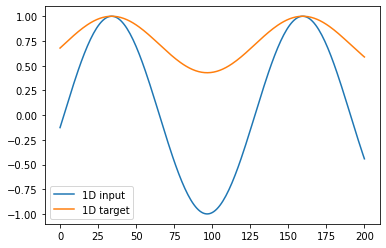

Shape surrogate quadrupels: (800, 4, 201)


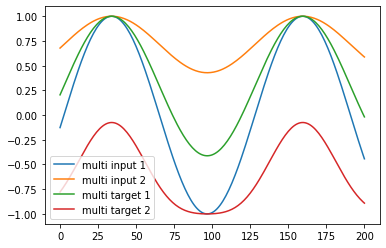

In [6]:
# Create windowed data 

# timeseries_dataset_from_array(data=x6_normalized,targets=None, sequence_length = seq_length, sequence_stride = 1, batch_size = batch_size, shuffle = False)

# create window size as seq len + 1 for easy cutting later on 
window_size = sequence_length + 1

# window size 21
x5_windowed = create_rolling_windows(x5_normalized,window_size) # 1D input; multi input 1
x6_windowed = create_rolling_windows(x6_normalized,window_size) # 1D target; multi input 2
x7_windowed = create_rolling_windows(x7_normalized,window_size) # multi target 1
x8_windowed = create_rolling_windows(x8_normalized,window_size) # multi target 2 

surrogate_pairs = np.array([x5_windowed, x6_windowed])
surrogate_pairs = np.swapaxes(surrogate_pairs,0,1)
print("Shape surrogate pairs: " + str(surrogate_pairs.shape))
plt.plot(surrogate_pairs[123][0], label = "1D input") 
plt.plot(surrogate_pairs[123][1], label = "1D target")
plt.legend()
plt.show()

surrogate_quadruples = np.array([x5_windowed, x6_windowed, x7_windowed, x8_windowed])
surrogate_quadruples = np.swapaxes(surrogate_quadruples,0,1)
print("Shape surrogate quadrupels: " + str(surrogate_quadruples.shape))
plt.plot(surrogate_quadruples[123][0], label = "multi input 1") 
plt.plot(surrogate_quadruples[123][1], label = "multi input 2")
plt.plot(surrogate_quadruples[123][2], label = "multi target 1")
plt.plot(surrogate_quadruples[123][3], label = "multi target 2")
plt.legend()
plt.show()



In [7]:
val_frac = 0.15 # amount of val; amount of test 

random.shuffle(surrogate_pairs)
num_val_samples = int(val_frac * len(surrogate_pairs))
num_train_samples = len(surrogate_pairs) - 2 * num_val_samples
train_pairs = surrogate_pairs[:num_train_samples]
val_pairs = surrogate_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = surrogate_pairs[num_train_samples + num_val_samples :]

print(f"{len(surrogate_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

800 total pairs
560 training pairs
120 validation pairs
120 test pairs


In [8]:
# Split pairs into inp and target 
train_inp_seqs = [pair[0] for pair in train_pairs]
train_target_seqs = [pair[1] for pair in train_pairs]
val_inp_seqs = [pair[0] for pair in val_pairs]
val_target_seqs = [pair[1] for pair in val_pairs]


# prepend 0 "start symbol" to all targets
'''
train_target_seqs = np.pad(train_target_seqs, pad_width = ((0,0),(1,0)), constant_values = 0)
val_target_seqs = np.pad(val_target_seqs, pad_width = ((0,0),(1,0)), constant_values = 0)
'''

print(np.shape(train_inp_seqs))
print(np.shape(train_target_seqs))
print(np.shape(val_inp_seqs))
print(np.shape(val_target_seqs))


(560, 201)
(560, 201)
(120, 201)
(120, 201)


In [9]:
        
def make_dataset(input_seqs,target_seqs):
    
    input_seqs = np.array(input_seqs).astype(float)
    target_seqs = np.array(target_seqs).astype(float)
    
    # Create dataset with inp sequence <-> target sequence pairs (both have length sequence_length)
    dataset = tf.data.Dataset.from_tensor_slices((input_seqs, target_seqs)) # tuple makes sure that inp matches correct target

    # batch 
    dataset = dataset.batch(batch_size)
    
    # format input/ outputs omitting last elem for decoder input and skipping first elem for target 
    # idea: instead of "word by word", show everything and do not omit first or last 
    dataset = dataset.map(format_dataset)
    
    return dataset.shuffle(2048).prefetch(16).cache()



def format_dataset(inp, target):
    
    
    # transformer architecture -> proceed word by word
    # full target sequence for input (i.e. 200)
    # 0 to N for decoder input (i.e. 200)
    # 1 to N+1 for target -> shifted by one (i.e. 200)
    
    return ({"encoder_inputs": inp[:, :-1], "decoder_inputs": target[:, :-1],}, target[:, 1:])
    #return ({"encoder_inputs": inp, "decoder_inputs": target[:, :-1],}, target)
    #return ({"encoder_inputs": inp, "decoder_inputs": target}, target)
    
    # orig
    # return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])
    

train_ds = make_dataset(train_inp_seqs,train_target_seqs)
val_ds = make_dataset(val_inp_seqs,val_target_seqs)

In [10]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 200)
inputs["decoder_inputs"].shape: (64, 200)
targets.shape: (64, 200)


# Transformer Model

In [55]:
log_debug = True
MASK_IGNORE_VALUE = 0 # prob change to sth like 9999, as in Embedding the orig input data is received, wich is not limited to (-1,1)

# info on MultiHeadAttention layer
# https://www.tensorflow.org/versions/r2.4/api_docs/python/tf/keras/layers/MultiHeadAttention
# query: Query Tensor of shape [B, T, dim]
# value: Value Tensor of shape [B, S, dim]
# key:   Optional key Tensor of shape [B, S, dim]


# Possible switches 
# place of tf.newaxis, maybe in last?

In [122]:



# embed_dim -> seq_len 

class TransformerEncoder(layers.Layer):
    def __init__(self, seq_len, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        
        self.seq_len = seq_len
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=seq_len
        )
        self.dense_proj = keras.Sequential(                        
            [layers.Dense(dense_dim, activation="tanh"), layers.Dense(seq_len),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        
        '''
        # masking not needed as input is always same size 
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="float64") # dtype int32 
             # None, 1, 1, 200 
            print("lul")
            print(mask)
            print(padding_mask)
        '''
        
        # Bring inputs into appropriate format 
        inputs = inputs[:,tf.newaxis,:]       # TODO 
        
        if log_debug:
            print("Encoder reshaped inputs")
            print(inputs)
        

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs # attention_mask=padding_mask
        )
        
        print("lul")
        print(inputs)
        print(attention_output)
        
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        
        if log_debug:
            print("Encoder proj_input")
            print(proj_input)
            print("Encoder proj_output")
            print(proj_output)
            print("Encoder Shape")
            print(self.layernorm_2(proj_input + proj_output))
            print()
            
        return self.layernorm_2(proj_input + proj_output)

    
    
#############
#############
#############
#############
    

# New positional embedding is directly added to the input sequence 
# embed_dim removed 
    
class PositionalEmbedding(layers.Layer):
    
    
    def __init__(self, sequence_length, model_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        
        # Save init values
        self.sequence_length = sequence_length
        self.d_model = model_dim 
        
        # create the positional embedding matrix 
        self.pos_embed = np.zeros((self.d_model,sequence_length)) 
        for pos in range(sequence_length):
            for i in range(0, self.d_model, 2):
                self.pos_embed[i,pos] = math.sin(pos / (10000 ** ((2 * i)/self.d_model)))
                if self.d_model > 1:
                    self.pos_embed[i + 1,pos] = math.cos(pos / (10000 ** ((2 * (i + 1))/self.d_model)))
        self.pos_embed = tf.convert_to_tensor(self.pos_embed)
        


    def call(self, inputs):
        
        # Inputs length 
        inputs_length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=inputs_length, delta=1)
        
        
        # Dummy embedding
        #pos_embedding = positions / length 
        
        # Actual positional embedding 
        pos_embedding = tf.reshape(self.pos_embed,[-1])
        
        
        # Cast for addition 
        inputs = tf.cast(inputs, "float64")
        
        if log_debug:
            print()
            print("Positional Embedding Return Value")
            print(inputs + pos_embedding)
            print()
    
    
        return inputs + pos_embedding 
        #return embedded_tokens + embedded_positions # original
        
        
        
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, MASK_IGNORE_VALUE)

    
    # allow saving 
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'model_dim': self.d_model
        })
        return config
    
    

# embed_dim -> seq_len

class TransformerDecoder(layers.Layer):
    def __init__(self, seq_len, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=seq_len
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=seq_len # potentially different key_dim here? 
        )
        self.dense_proj = keras.Sequential(                         
            [layers.Dense(latent_dim, activation="tanh"), layers.Dense(seq_len),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

        
    def call(self, inputs, encoder_outputs, mask=None):
        
        causal_mask = self.get_causal_attention_mask(inputs)
    
        
        # masking not needed since all episodes have same length
        '''
        if mask is not None:
            print(mask)
            #mask = tf.ones((64,200,300))
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="float64") # dtype int32
            padding_mask = tf.minimum(padding_mask, tf.cast(causal_mask, dtype="float64")) 
        '''
        padding_mask = causal_mask
        
        # Reshape inputs 
        inputs = inputs[:,tf.newaxis,:] # TODO: place of tf.newaxis? 
        
        
        if log_debug:
            print("Decoder Inputs:")
            print(inputs)
        
        
        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs #, attention_mask=causal_mask
        )
        
        if log_debug:
            print("Decoder attention_output_1")
            print(attention_output_1)
        
        out_1 = self.layernorm_1(inputs + attention_output_1)
        
        if log_debug:
            print("Decoder out_1")
            print(out_1)

        # add dim only for input encoded sequences, not actually computed ones 
        if encoder_outputs.shape[1] != 1:
            encoder_outputs = encoder_outputs[:,tf.newaxis,:] # added 
        
        if log_debug:
            print("Decoder encoder_outputs")
            print(encoder_outputs)
        
        #padding_mask = padding_mask[:,:,tf.newaxis]
        #print("Decoder padding_mask")
        #print(padding_mask)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            #attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        
        
        if log_debug:
            print("Decoder Shape")
            print(self.layernorm_3(out_2 + proj_output))
            print()
        
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        
        return tf.ones(tf.shape(inputs))
    
        
        input_shape = tf.shape(inputs)
        print("causal mask")
        print(inputs)
        print(input_shape)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        print(i)
        j = tf.range(sequence_length)
        print(j)
        mask = tf.cast(i >= j, dtype="float64") # dtype int32 
        print(mask)
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        print(mask)
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        print(mult)
        return tf.tile(mask, mult)





In [123]:

embed_dim = 1
latent_dim = 2048
num_heads = 8

# from above
# batch_size = 64
# sequence_length = 200

# input shape should not include batch size 
# batch_size = batch_size,

encoder_inputs = keras.Input(shape=(sequence_length), dtype="float64", name="encoder_inputs")
x_encoder = PositionalEmbedding(sequence_length, model_dim=1)(encoder_inputs)

print("Encoder Inputs:")
print(encoder_inputs)
print("x_encoder:")
print(x_encoder)
print()



encoder_outputs = TransformerEncoder(seq_len = sequence_length, dense_dim = latent_dim, num_heads = num_heads)(x_encoder)
encoder = keras.Model(inputs=encoder_inputs, outputs=encoder_outputs)

encoder_outputs = layers.Flatten()(encoder_outputs)

print("encoder_outputs")
print(encoder_outputs)






decoder_inputs = keras.Input(shape=(sequence_length), dtype="float64", name="decoder_inputs") 
encoded_seq_inputs = keras.Input(shape=(sequence_length), name="decoder_state_inputs") 
x_decoder = PositionalEmbedding(sequence_length,model_dim=1)(decoder_inputs)
print()
print("decoder_inputs")
print(decoder_inputs)
print("encoded_seq_inputs")
print(encoded_seq_inputs)
print("x_decoder")
print(x_decoder)
print()
#x_decoder = layers.Flatten()(x_decoder)


x_decoder = TransformerDecoder(seq_len = sequence_length, latent_dim = latent_dim, num_heads = num_heads)(x_decoder, encoded_seq_inputs)

x_decoder = layers.Dropout(0.5)(x_decoder) # TODO: different rate? 




# decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x) # orig

#decoder_outputs = layers.Dense(sequence_length, activation="softmax")(x_decoder)
#decoder_outputs = layers.Dense(sequence_length, activation="tanh")(x_decoder) 
#decoder_outputs = layers.GlobalAveragePooling1D()(x_decoder)
##decoder_outputs1 = layers.Flatten(input_shape=(batch_size,embed_dim,sequence_length))(x_decoder)
#decoder_outputs = layers.Dense(200, activation="tanh", input_shape=(batch_size,embed_dim*sequence_length))(decoder_outputs)

decoder_outputs = layers.Flatten()(x_decoder)

print("Flatten decoder_outputs")
print(decoder_outputs)




decoder = keras.Model(inputs=[decoder_inputs, encoded_seq_inputs], outputs=decoder_outputs)




decoder_outputs = decoder([decoder_inputs, encoder_outputs])



transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)





Positional Embedding Return Value
Tensor("positional_embedding_45/add:0", shape=(None, 200), dtype=float64)

Encoder Inputs:
KerasTensor(type_spec=TensorSpec(shape=(None, 200), dtype=tf.float64, name='encoder_inputs'), name='encoder_inputs', description="created by layer 'encoder_inputs'")
x_encoder:
KerasTensor(type_spec=TensorSpec(shape=(None, 200), dtype=tf.float64, name=None), name='positional_embedding_45/add_1:0', description="created by layer 'positional_embedding_45'")

Encoder reshaped inputs
Tensor("transformer_encoder_22/strided_slice:0", shape=(None, 1, 200), dtype=float32)
lul
Tensor("transformer_encoder_22/strided_slice:0", shape=(None, 1, 200), dtype=float32)
Tensor("transformer_encoder_22/multi_head_attention_66/attention_output/add:0", shape=(None, 1, 200), dtype=float32)
Encoder proj_input
Tensor("transformer_encoder_22/layer_normalization_110/add:0", shape=(None, 1, 200), dtype=float32)
Encoder proj_output
Tensor("transformer_encoder_22/sequential_44/dense_89/BiasAd

In [124]:
#print(1/0)

In [125]:
#error_sq = tf.math.squared_difference(y_pred, y_true)

def custom_mse(y_true, y_pred):
    
    print(y_true)
    print(y_pred)

    
    #squared_difference = tf.square(y_true - y_pred[:,0,:])
    
    #squared_difference = tf.square(y_true - y_pred[:,:,-1]) # last entry of each [prob not correct like this]
    
    
    #squared_difference = tf.square(y_true - y_pred[:,-1,:]) # last pred class, all values 
    squared_difference = tf.square(y_true - y_pred)

    
    return tf.reduce_mean(squared_difference) 


In [127]:
epochs = 400  # min 30 

transformer.summary()
transformer.compile(
    "adam", loss="mse", metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'] # rmsprop # sparse_categorical_crossentropy # mse
)

transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[WandbCallback()])

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
positional_embedding_45 (Positi (None, 200)          0           encoder_inputs[0][0]             
__________________________________________________________________________________________________
transformer_encoder_22 (Transfo (None, 1, 200)       2107248     positional_embedding_45[0][0]    
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 200)]        0                                            
________________________________________________________________________________________

wandb: ERROR Can't save model, h5py returned error: Layer TransformerEncoder has arguments in `__init__` and therefore must override `get_config`.


Epoch 3/400
9/9 [==============================] - 1s 72ms/step - loss: 0.4146 - mean_squared_error: 0.4146 - mean_absolute_error: 0.4778 - mean_absolute_percentage_error: 67.2906 - cosine_proximity: 0.5617 - val_loss: 0.2670 - val_mean_squared_error: 0.2670 - val_mean_absolute_error: 0.4520 - val_mean_absolute_percentage_error: 63.7443 - val_cosine_proximity: 0.7720
Epoch 4/400
9/9 [==============================] - 0s 53ms/step - loss: 0.4022 - mean_squared_error: 0.4022 - mean_absolute_error: 0.4665 - mean_absolute_percentage_error: 66.3573 - cosine_proximity: 0.5748 - val_loss: 0.2579 - val_mean_squared_error: 0.2579 - val_mean_absolute_error: 0.4452 - val_mean_absolute_percentage_error: 62.1344 - val_cosine_proximity: 0.7937
Epoch 5/400
9/9 [==============================] - 1s 63ms/step - loss: 0.3862 - mean_squared_error: 0.3862 - mean_absolute_error: 0.4560 - mean_absolute_percentage_error: 64.4660 - cosine_proximity: 0.5921 - val_loss: 0.2463 - val_mean_squared_error: 0.2463 -

9/9 [==============================] - 0s 53ms/step - loss: 0.2912 - mean_squared_error: 0.2912 - mean_absolute_error: 0.3937 - mean_absolute_percentage_error: 55.6710 - cosine_proximity: 0.6914 - val_loss: 0.1495 - val_mean_squared_error: 0.1495 - val_mean_absolute_error: 0.3630 - val_mean_absolute_percentage_error: 50.6715 - val_cosine_proximity: 0.9759
Epoch 26/400
9/9 [==============================] - 0s 50ms/step - loss: 0.2912 - mean_squared_error: 0.2912 - mean_absolute_error: 0.3956 - mean_absolute_percentage_error: 55.9005 - cosine_proximity: 0.6904 - val_loss: 0.1477 - val_mean_squared_error: 0.1477 - val_mean_absolute_error: 0.3622 - val_mean_absolute_percentage_error: 50.6681 - val_cosine_proximity: 0.9782
Epoch 27/400
9/9 [==============================] - 0s 50ms/step - loss: 0.2905 - mean_squared_error: 0.2905 - mean_absolute_error: 0.3955 - mean_absolute_percentage_error: 55.8224 - cosine_proximity: 0.6912 - val_loss: 0.1472 - val_mean_squared_error: 0.1472 - val_mean_

9/9 [==============================] - 0s 54ms/step - loss: 0.2782 - mean_squared_error: 0.2782 - mean_absolute_error: 0.3832 - mean_absolute_percentage_error: 53.9819 - cosine_proximity: 0.7049 - val_loss: 0.1406 - val_mean_squared_error: 0.1406 - val_mean_absolute_error: 0.3600 - val_mean_absolute_percentage_error: 50.2942 - val_cosine_proximity: 0.9966
Epoch 48/400
9/9 [==============================] - 0s 52ms/step - loss: 0.2797 - mean_squared_error: 0.2797 - mean_absolute_error: 0.3852 - mean_absolute_percentage_error: 54.4136 - cosine_proximity: 0.7023 - val_loss: 0.1415 - val_mean_squared_error: 0.1415 - val_mean_absolute_error: 0.3604 - val_mean_absolute_percentage_error: 50.2097 - val_cosine_proximity: 0.9969
Epoch 49/400
9/9 [==============================] - 0s 50ms/step - loss: 0.2819 - mean_squared_error: 0.2819 - mean_absolute_error: 0.3873 - mean_absolute_percentage_error: 54.5409 - cosine_proximity: 0.6998 - val_loss: 0.1409 - val_mean_squared_error: 0.1409 - val_mean_

9/9 [==============================] - 0s 53ms/step - loss: 0.2774 - mean_squared_error: 0.2774 - mean_absolute_error: 0.3757 - mean_absolute_percentage_error: 52.8899 - cosine_proximity: 0.7046 - val_loss: 0.1412 - val_mean_squared_error: 0.1412 - val_mean_absolute_error: 0.3609 - val_mean_absolute_percentage_error: 50.2458 - val_cosine_proximity: 0.9985
Epoch 70/400
9/9 [==============================] - 0s 50ms/step - loss: 0.2776 - mean_squared_error: 0.2776 - mean_absolute_error: 0.3756 - mean_absolute_percentage_error: 52.8122 - cosine_proximity: 0.7045 - val_loss: 0.1409 - val_mean_squared_error: 0.1409 - val_mean_absolute_error: 0.3610 - val_mean_absolute_percentage_error: 50.3139 - val_cosine_proximity: 0.9986
Epoch 71/400
9/9 [==============================] - 0s 50ms/step - loss: 0.2786 - mean_squared_error: 0.2786 - mean_absolute_error: 0.3762 - mean_absolute_percentage_error: 52.8724 - cosine_proximity: 0.7031 - val_loss: 0.1414 - val_mean_squared_error: 0.1414 - val_mean_

9/9 [==============================] - 0s 52ms/step - loss: 0.2774 - mean_squared_error: 0.2774 - mean_absolute_error: 0.3714 - mean_absolute_percentage_error: 52.1292 - cosine_proximity: 0.7045 - val_loss: 0.1427 - val_mean_squared_error: 0.1427 - val_mean_absolute_error: 0.3628 - val_mean_absolute_percentage_error: 50.4284 - val_cosine_proximity: 0.9991
Epoch 92/400
9/9 [==============================] - 0s 49ms/step - loss: 0.2770 - mean_squared_error: 0.2770 - mean_absolute_error: 0.3698 - mean_absolute_percentage_error: 51.7851 - cosine_proximity: 0.7050 - val_loss: 0.1427 - val_mean_squared_error: 0.1427 - val_mean_absolute_error: 0.3626 - val_mean_absolute_percentage_error: 50.3701 - val_cosine_proximity: 0.9992
Epoch 93/400
9/9 [==============================] - 0s 51ms/step - loss: 0.2754 - mean_squared_error: 0.2754 - mean_absolute_error: 0.3685 - mean_absolute_percentage_error: 51.7406 - cosine_proximity: 0.7070 - val_loss: 0.1430 - val_mean_squared_error: 0.1430 - val_mean_

9/9 [==============================] - 0s 51ms/step - loss: 0.2769 - mean_squared_error: 0.2769 - mean_absolute_error: 0.3695 - mean_absolute_percentage_error: 51.8152 - cosine_proximity: 0.7049 - val_loss: 0.1430 - val_mean_squared_error: 0.1430 - val_mean_absolute_error: 0.3628 - val_mean_absolute_percentage_error: 50.3234 - val_cosine_proximity: 0.9994
Epoch 114/400
9/9 [==============================] - 0s 51ms/step - loss: 0.2757 - mean_squared_error: 0.2757 - mean_absolute_error: 0.3689 - mean_absolute_percentage_error: 51.8605 - cosine_proximity: 0.7064 - val_loss: 0.1428 - val_mean_squared_error: 0.1428 - val_mean_absolute_error: 0.3629 - val_mean_absolute_percentage_error: 50.4071 - val_cosine_proximity: 0.9994
Epoch 115/400
9/9 [==============================] - 0s 50ms/step - loss: 0.2784 - mean_squared_error: 0.2784 - mean_absolute_error: 0.3716 - mean_absolute_percentage_error: 52.1099 - cosine_proximity: 0.7030 - val_loss: 0.1430 - val_mean_squared_error: 0.1430 - val_mea

9/9 [==============================] - 0s 50ms/step - loss: 0.2747 - mean_squared_error: 0.2747 - mean_absolute_error: 0.3651 - mean_absolute_percentage_error: 51.2802 - cosine_proximity: 0.7075 - val_loss: 0.1423 - val_mean_squared_error: 0.1423 - val_mean_absolute_error: 0.3623 - val_mean_absolute_percentage_error: 50.3119 - val_cosine_proximity: 0.9996
Epoch 136/400
9/9 [==============================] - 0s 48ms/step - loss: 0.2766 - mean_squared_error: 0.2766 - mean_absolute_error: 0.3670 - mean_absolute_percentage_error: 51.4466 - cosine_proximity: 0.7050 - val_loss: 0.1421 - val_mean_squared_error: 0.1421 - val_mean_absolute_error: 0.3621 - val_mean_absolute_percentage_error: 50.2616 - val_cosine_proximity: 0.9996
Epoch 137/400
9/9 [==============================] - 0s 48ms/step - loss: 0.2748 - mean_squared_error: 0.2748 - mean_absolute_error: 0.3650 - mean_absolute_percentage_error: 51.2561 - cosine_proximity: 0.7072 - val_loss: 0.1420 - val_mean_squared_error: 0.1420 - val_mea

9/9 [==============================] - 1s 60ms/step - loss: 0.2753 - mean_squared_error: 0.2753 - mean_absolute_error: 0.3627 - mean_absolute_percentage_error: 50.8610 - cosine_proximity: 0.7067 - val_loss: 0.1410 - val_mean_squared_error: 0.1410 - val_mean_absolute_error: 0.3611 - val_mean_absolute_percentage_error: 50.1851 - val_cosine_proximity: 0.9995
Epoch 158/400
9/9 [==============================] - 1s 64ms/step - loss: 0.2752 - mean_squared_error: 0.2752 - mean_absolute_error: 0.3638 - mean_absolute_percentage_error: 51.0309 - cosine_proximity: 0.7067 - val_loss: 0.1414 - val_mean_squared_error: 0.1414 - val_mean_absolute_error: 0.3604 - val_mean_absolute_percentage_error: 49.9244 - val_cosine_proximity: 0.9994
Epoch 159/400
9/9 [==============================] - 1s 62ms/step - loss: 0.2744 - mean_squared_error: 0.2744 - mean_absolute_error: 0.3647 - mean_absolute_percentage_error: 51.2593 - cosine_proximity: 0.7077 - val_loss: 0.1405 - val_mean_squared_error: 0.1405 - val_mea

9/9 [==============================] - 1s 65ms/step - loss: 0.2766 - mean_squared_error: 0.2766 - mean_absolute_error: 0.3624 - mean_absolute_percentage_error: 50.8507 - cosine_proximity: 0.7049 - val_loss: 0.1406 - val_mean_squared_error: 0.1406 - val_mean_absolute_error: 0.3605 - val_mean_absolute_percentage_error: 50.0864 - val_cosine_proximity: 0.9996
Epoch 180/400
9/9 [==============================] - 1s 66ms/step - loss: 0.2766 - mean_squared_error: 0.2766 - mean_absolute_error: 0.3616 - mean_absolute_percentage_error: 50.6212 - cosine_proximity: 0.7050 - val_loss: 0.1407 - val_mean_squared_error: 0.1407 - val_mean_absolute_error: 0.3603 - val_mean_absolute_percentage_error: 50.0191 - val_cosine_proximity: 0.9996
Epoch 181/400
9/9 [==============================] - 1s 68ms/step - loss: 0.2765 - mean_squared_error: 0.2765 - mean_absolute_error: 0.3613 - mean_absolute_percentage_error: 50.5240 - cosine_proximity: 0.7051 - val_loss: 0.1406 - val_mean_squared_error: 0.1406 - val_mea

9/9 [==============================] - 1s 65ms/step - loss: 0.2756 - mean_squared_error: 0.2756 - mean_absolute_error: 0.3606 - mean_absolute_percentage_error: 50.5009 - cosine_proximity: 0.7065 - val_loss: 0.1404 - val_mean_squared_error: 0.1404 - val_mean_absolute_error: 0.3602 - val_mean_absolute_percentage_error: 50.0347 - val_cosine_proximity: 0.9996
Epoch 202/400
9/9 [==============================] - 1s 65ms/step - loss: 0.2754 - mean_squared_error: 0.2754 - mean_absolute_error: 0.3600 - mean_absolute_percentage_error: 50.4326 - cosine_proximity: 0.7063 - val_loss: 0.1404 - val_mean_squared_error: 0.1404 - val_mean_absolute_error: 0.3601 - val_mean_absolute_percentage_error: 49.9989 - val_cosine_proximity: 0.9996
Epoch 203/400
9/9 [==============================] - 1s 63ms/step - loss: 0.2744 - mean_squared_error: 0.2744 - mean_absolute_error: 0.3587 - mean_absolute_percentage_error: 50.2452 - cosine_proximity: 0.7079 - val_loss: 0.1402 - val_mean_squared_error: 0.1402 - val_mea

9/9 [==============================] - 1s 60ms/step - loss: 0.2735 - mean_squared_error: 0.2735 - mean_absolute_error: 0.3585 - mean_absolute_percentage_error: 50.3802 - cosine_proximity: 0.7089 - val_loss: 0.1405 - val_mean_squared_error: 0.1405 - val_mean_absolute_error: 0.3602 - val_mean_absolute_percentage_error: 49.9992 - val_cosine_proximity: 0.9996
Epoch 224/400
9/9 [==============================] - 1s 64ms/step - loss: 0.2753 - mean_squared_error: 0.2753 - mean_absolute_error: 0.3602 - mean_absolute_percentage_error: 50.4613 - cosine_proximity: 0.7070 - val_loss: 0.1407 - val_mean_squared_error: 0.1407 - val_mean_absolute_error: 0.3602 - val_mean_absolute_percentage_error: 49.9813 - val_cosine_proximity: 0.9996
Epoch 225/400
9/9 [==============================] - 0s 51ms/step - loss: 0.2750 - mean_squared_error: 0.2750 - mean_absolute_error: 0.3606 - mean_absolute_percentage_error: 50.6313 - cosine_proximity: 0.7072 - val_loss: 0.1407 - val_mean_squared_error: 0.1407 - val_mea

9/9 [==============================] - 0s 50ms/step - loss: 0.2750 - mean_squared_error: 0.2750 - mean_absolute_error: 0.3608 - mean_absolute_percentage_error: 50.5172 - cosine_proximity: 0.7072 - val_loss: 0.1403 - val_mean_squared_error: 0.1403 - val_mean_absolute_error: 0.3600 - val_mean_absolute_percentage_error: 50.0110 - val_cosine_proximity: 0.9996
Epoch 246/400
9/9 [==============================] - 0s 48ms/step - loss: 0.2753 - mean_squared_error: 0.2753 - mean_absolute_error: 0.3614 - mean_absolute_percentage_error: 50.6110 - cosine_proximity: 0.7065 - val_loss: 0.1399 - val_mean_squared_error: 0.1399 - val_mean_absolute_error: 0.3599 - val_mean_absolute_percentage_error: 50.0580 - val_cosine_proximity: 0.9996
Epoch 247/400
9/9 [==============================] - 0s 48ms/step - loss: 0.2767 - mean_squared_error: 0.2767 - mean_absolute_error: 0.3636 - mean_absolute_percentage_error: 50.9172 - cosine_proximity: 0.7049 - val_loss: 0.1405 - val_mean_squared_error: 0.1405 - val_mea

9/9 [==============================] - 0s 52ms/step - loss: 0.2739 - mean_squared_error: 0.2739 - mean_absolute_error: 0.3577 - mean_absolute_percentage_error: 50.2362 - cosine_proximity: 0.7087 - val_loss: 0.1401 - val_mean_squared_error: 0.1401 - val_mean_absolute_error: 0.3599 - val_mean_absolute_percentage_error: 50.0100 - val_cosine_proximity: 0.9997
Epoch 268/400
9/9 [==============================] - 0s 49ms/step - loss: 0.2747 - mean_squared_error: 0.2747 - mean_absolute_error: 0.3579 - mean_absolute_percentage_error: 50.1037 - cosine_proximity: 0.7075 - val_loss: 0.1400 - val_mean_squared_error: 0.1400 - val_mean_absolute_error: 0.3599 - val_mean_absolute_percentage_error: 50.0118 - val_cosine_proximity: 0.9997
Epoch 269/400
9/9 [==============================] - 0s 48ms/step - loss: 0.2743 - mean_squared_error: 0.2743 - mean_absolute_error: 0.3572 - mean_absolute_percentage_error: 50.0111 - cosine_proximity: 0.7078 - val_loss: 0.1401 - val_mean_squared_error: 0.1401 - val_mea

9/9 [==============================] - 0s 50ms/step - loss: 0.2739 - mean_squared_error: 0.2739 - mean_absolute_error: 0.3593 - mean_absolute_percentage_error: 50.4033 - cosine_proximity: 0.7084 - val_loss: 0.1400 - val_mean_squared_error: 0.1400 - val_mean_absolute_error: 0.3597 - val_mean_absolute_percentage_error: 49.9701 - val_cosine_proximity: 0.9997
Epoch 290/400
9/9 [==============================] - 0s 47ms/step - loss: 0.2749 - mean_squared_error: 0.2749 - mean_absolute_error: 0.3601 - mean_absolute_percentage_error: 50.4885 - cosine_proximity: 0.7072 - val_loss: 0.1400 - val_mean_squared_error: 0.1400 - val_mean_absolute_error: 0.3599 - val_mean_absolute_percentage_error: 50.0394 - val_cosine_proximity: 0.9997
Epoch 291/400
9/9 [==============================] - 0s 48ms/step - loss: 0.2753 - mean_squared_error: 0.2753 - mean_absolute_error: 0.3604 - mean_absolute_percentage_error: 50.4900 - cosine_proximity: 0.7064 - val_loss: 0.1402 - val_mean_squared_error: 0.1402 - val_mea

9/9 [==============================] - 0s 50ms/step - loss: 0.2747 - mean_squared_error: 0.2747 - mean_absolute_error: 0.3581 - mean_absolute_percentage_error: 50.1734 - cosine_proximity: 0.7070 - val_loss: 0.1400 - val_mean_squared_error: 0.1400 - val_mean_absolute_error: 0.3597 - val_mean_absolute_percentage_error: 49.9674 - val_cosine_proximity: 0.9997
Epoch 312/400
9/9 [==============================] - 0s 49ms/step - loss: 0.2762 - mean_squared_error: 0.2762 - mean_absolute_error: 0.3599 - mean_absolute_percentage_error: 50.4046 - cosine_proximity: 0.7054 - val_loss: 0.1399 - val_mean_squared_error: 0.1399 - val_mean_absolute_error: 0.3598 - val_mean_absolute_percentage_error: 50.0200 - val_cosine_proximity: 0.9997
Epoch 313/400
9/9 [==============================] - 0s 48ms/step - loss: 0.2745 - mean_squared_error: 0.2745 - mean_absolute_error: 0.3576 - mean_absolute_percentage_error: 50.0801 - cosine_proximity: 0.7075 - val_loss: 0.1401 - val_mean_squared_error: 0.1401 - val_mea

9/9 [==============================] - 0s 54ms/step - loss: 0.2751 - mean_squared_error: 0.2751 - mean_absolute_error: 0.3601 - mean_absolute_percentage_error: 50.4370 - cosine_proximity: 0.7067 - val_loss: 0.1399 - val_mean_squared_error: 0.1399 - val_mean_absolute_error: 0.3599 - val_mean_absolute_percentage_error: 50.0446 - val_cosine_proximity: 0.9997
Epoch 334/400
9/9 [==============================] - 1s 70ms/step - loss: 0.2737 - mean_squared_error: 0.2737 - mean_absolute_error: 0.3582 - mean_absolute_percentage_error: 50.2334 - cosine_proximity: 0.7086 - val_loss: 0.1399 - val_mean_squared_error: 0.1399 - val_mean_absolute_error: 0.3597 - val_mean_absolute_percentage_error: 49.9680 - val_cosine_proximity: 0.9997
Epoch 335/400
9/9 [==============================] - 1s 66ms/step - loss: 0.2747 - mean_squared_error: 0.2747 - mean_absolute_error: 0.3594 - mean_absolute_percentage_error: 50.3385 - cosine_proximity: 0.7075 - val_loss: 0.1405 - val_mean_squared_error: 0.1405 - val_mea

9/9 [==============================] - 0s 51ms/step - loss: 0.2767 - mean_squared_error: 0.2767 - mean_absolute_error: 0.3627 - mean_absolute_percentage_error: 50.8028 - cosine_proximity: 0.7047 - val_loss: 0.1396 - val_mean_squared_error: 0.1396 - val_mean_absolute_error: 0.3596 - val_mean_absolute_percentage_error: 50.0384 - val_cosine_proximity: 0.9996
Epoch 356/400
9/9 [==============================] - 0s 50ms/step - loss: 0.2771 - mean_squared_error: 0.2771 - mean_absolute_error: 0.3636 - mean_absolute_percentage_error: 50.9899 - cosine_proximity: 0.7041 - val_loss: 0.1402 - val_mean_squared_error: 0.1402 - val_mean_absolute_error: 0.3597 - val_mean_absolute_percentage_error: 49.9184 - val_cosine_proximity: 0.9997
Epoch 357/400
9/9 [==============================] - 0s 48ms/step - loss: 0.2751 - mean_squared_error: 0.2751 - mean_absolute_error: 0.3598 - mean_absolute_percentage_error: 50.4211 - cosine_proximity: 0.7068 - val_loss: 0.1398 - val_mean_squared_error: 0.1398 - val_mea

9/9 [==============================] - 0s 50ms/step - loss: 0.2750 - mean_squared_error: 0.2750 - mean_absolute_error: 0.3582 - mean_absolute_percentage_error: 50.1416 - cosine_proximity: 0.7068 - val_loss: 0.1398 - val_mean_squared_error: 0.1398 - val_mean_absolute_error: 0.3597 - val_mean_absolute_percentage_error: 50.0166 - val_cosine_proximity: 0.9997
Epoch 378/400
9/9 [==============================] - 0s 49ms/step - loss: 0.2757 - mean_squared_error: 0.2757 - mean_absolute_error: 0.3593 - mean_absolute_percentage_error: 50.3070 - cosine_proximity: 0.7063 - val_loss: 0.1399 - val_mean_squared_error: 0.1399 - val_mean_absolute_error: 0.3598 - val_mean_absolute_percentage_error: 49.9996 - val_cosine_proximity: 0.9997
Epoch 379/400
9/9 [==============================] - 0s 48ms/step - loss: 0.2755 - mean_squared_error: 0.2755 - mean_absolute_error: 0.3588 - mean_absolute_percentage_error: 50.1930 - cosine_proximity: 0.7065 - val_loss: 0.1401 - val_mean_squared_error: 0.1401 - val_mea

9/9 [==============================] - 0s 51ms/step - loss: 0.2756 - mean_squared_error: 0.2756 - mean_absolute_error: 0.3594 - mean_absolute_percentage_error: 50.2844 - cosine_proximity: 0.7063 - val_loss: 0.1398 - val_mean_squared_error: 0.1398 - val_mean_absolute_error: 0.3596 - val_mean_absolute_percentage_error: 49.9769 - val_cosine_proximity: 0.9997
Epoch 400/400
9/9 [==============================] - 0s 49ms/step - loss: 0.2729 - mean_squared_error: 0.2729 - mean_absolute_error: 0.3567 - mean_absolute_percentage_error: 50.0179 - cosine_proximity: 0.7097 - val_loss: 0.1397 - val_mean_squared_error: 0.1397 - val_mean_absolute_error: 0.3597 - val_mean_absolute_percentage_error: 50.0215 - val_cosine_proximity: 0.9997


In [128]:

max_decoded_sequence_length = 200

def decode_sequence(input_sequence, first_elem):
    
    decoded_sequence = np.zeros((max_decoded_sequence_length)) # text vectorization layer generates fixed len vector even for shorter input 
    decoded_sequence[0] = first_elem
    
    for i in range(max_decoded_sequence_length):
        
        #print("decode seq")
        #print(decoded_sequence)
        
        predictions = transformer.predict([np.array([input_sequence,]), np.array([decoded_sequence,])])  
        
        #print("predictions")
        #print(np.shape(predictions))
        #print(predictions)
        
        
        
        # todo: fix such that actual full seq is considered here, i.e. fix dataset by eg. shift for targets incl. start target -> making 200 -> 201
        if i < max_decoded_sequence_length - 1:
            sampled_token = predictions[0, i + 1]
            decoded_sequence[i+1] = sampled_token 
    
    return np.append(decoded_sequence, sampled_token) # add last token 




Positional Embedding Return Value
Tensor("transformer/positional_embedding_45/add:0", shape=(None, 200), dtype=float64)

Encoder reshaped inputs
Tensor("transformer/transformer_encoder_22/strided_slice:0", shape=(None, 1, 200), dtype=float32)
lul
Tensor("transformer/transformer_encoder_22/strided_slice:0", shape=(None, 1, 200), dtype=float32)
Tensor("transformer/transformer_encoder_22/multi_head_attention_66/attention_output/add:0", shape=(None, 1, 200), dtype=float32)
Encoder proj_input
Tensor("transformer/transformer_encoder_22/layer_normalization_110/add:0", shape=(None, 1, 200), dtype=float32)
Encoder proj_output
Tensor("transformer/transformer_encoder_22/sequential_44/dense_89/BiasAdd:0", shape=(None, 1, 200), dtype=float32)
Encoder Shape
Tensor("transformer/transformer_encoder_22/layer_normalization_111/add:0", shape=(None, 1, 200), dtype=float32)


Positional Embedding Return Value
Tensor("transformer/model_45/positional_embedding_46/add:0", shape=(None, 200), dtype=float64)

D

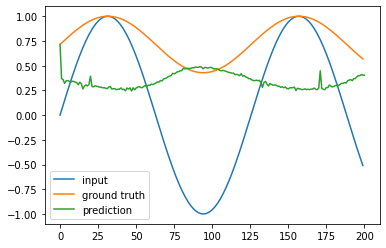

In [129]:
inp_seq = train_inp_seqs[0][:-1]
true_seq = train_target_seqs[0][:-1]
pred_seq = decode_sequence(inp_seq, true_seq[0])



plt.plot(inp_seq, label = "input")
plt.plot(true_seq, label = "ground truth")
plt.plot(pred_seq, label = "prediction")
plt.legend()
plt.show()

In [152]:
spa_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
)


decoded_sentence = ["[start] testword [end]"]
spa_vectorization.adapt(decoded_sentence)

print(spa_vectorization(np.array(decoded_sentence)))

print(spa_vectorization([decoded_sentence])[:, :-1])

tf.Tensor(
[[3 2 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 201), dtype=int64)
tf.Tensor(
[[3 2 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 200), dtype=int64)


In [ ]:
print(1/0)

In [ ]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

In [ ]:
print(1/0)

# Other Models

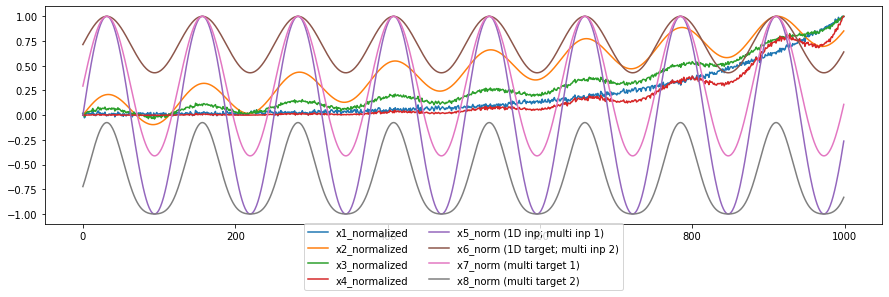

In [163]:
# Create surrogate sample data 

surrogate_samples = 1000
t = np.linspace(0, 50, surrogate_samples)

# inputs, outputs 
x1 = np.exp(0.1 * t) + np.random.normal(0, 2, surrogate_samples)
x2 = 10 * np.sin(t) + t 
x3 = x1 + x2 
x4 = x1 * x2 / 100 
x5 = np.sin(t) * 0.8
x6 = x5 * 0.2 + 0.4
x7 = x5 + x6 
x8 = x5 * x6 - 0.5

x1_factor = np.max(np.abs(x1))
x2_factor = np.max(np.abs(x2))
x3_factor = np.max(np.abs(x3))
x4_factor = np.max(np.abs(x4))
x5_factor = np.max(np.abs(x5))
x6_factor = np.max(np.abs(x6))
x7_factor = np.max(np.abs(x7))
x8_factor = np.max(np.abs(x8))


# normalize per time series
x1_normalized = x1 / x1_factor
x2_normalized = x2 / x2_factor
x3_normalized = x3 / x3_factor
x4_normalized = x4 / x4_factor
x5_normalized = x5 / x5_factor
x6_normalized = x6 / x6_factor
x7_normalized = x7 / x7_factor
x8_normalized = x8 / x8_factor


plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_normalized)), x1_normalized, label='x1_normalized')
plt.plot(range(len(x2_normalized)), x2_normalized, label='x2_normalized')
plt.plot(range(len(x3_normalized)), x3_normalized, label='x3_normalized')
plt.plot(range(len(x4_normalized)), x4_normalized, label='x4_normalized')
plt.plot(range(len(x5_normalized)), x5_normalized, label='x5_norm (1D inp; multi inp 1)')
plt.plot(range(len(x6_normalized)), x6_normalized, label='x6_norm (1D target; multi inp 2)')
plt.plot(range(len(x7_normalized)), x7_normalized, label='x7_norm (multi target 1)')
plt.plot(range(len(x8_normalized)), x8_normalized, label='x8_norm (multi target 2)')
plt.legend(loc = "center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [164]:
batch_size = 64
sequence_length = 200

Shape surrogate pairs: (801, 2, 200)


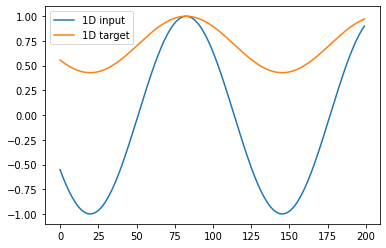

Shape surrogate quadrupels: (801, 4, 200)


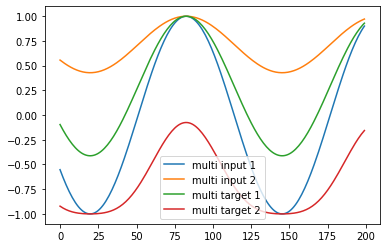

In [169]:
# Create windowed data 

# timeseries_dataset_from_array(data=x6_normalized,targets=None, sequence_length = seq_length, sequence_stride = 1, batch_size = batch_size, shuffle = False)

# create window size as seq len
window_size = sequence_length

# window size 21
x5_windowed = create_rolling_windows(x5_normalized,window_size) # 1D input; multi input 1
x6_windowed = create_rolling_windows(x6_normalized,window_size) # 1D target; multi input 2
x7_windowed = create_rolling_windows(x7_normalized,window_size) # multi target 1
x8_windowed = create_rolling_windows(x8_normalized,window_size) # multi target 2 


surrogate_pairs = np.array([x5_windowed, x6_windowed])
surrogate_pairs = np.swapaxes(surrogate_pairs,0,1)
print("Shape surrogate pairs: " + str(surrogate_pairs.shape))
plt.plot(surrogate_pairs[200][0], label = "1D input") 
plt.plot(surrogate_pairs[200][1], label = "1D target")
plt.legend()
plt.show()

surrogate_quadruples = np.array([x5_windowed, x6_windowed, x7_windowed, x8_windowed])
surrogate_quadruples = np.swapaxes(surrogate_quadruples,0,1)
print("Shape surrogate quadrupels: " + str(surrogate_quadruples.shape))
plt.plot(surrogate_quadruples[200][0], label = "multi input 1") 
plt.plot(surrogate_quadruples[200][1], label = "multi input 2")
plt.plot(surrogate_quadruples[200][2], label = "multi target 1")
plt.plot(surrogate_quadruples[200][3], label = "multi target 2")
plt.legend()
plt.show()



In [170]:
val_frac = 0.15 # amount of val; amount of test 

random.shuffle(surrogate_pairs)
num_val_samples = int(val_frac * len(surrogate_pairs))
num_train_samples = len(surrogate_pairs) - 2 * num_val_samples
train_pairs = surrogate_pairs[:num_train_samples]
val_pairs = surrogate_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = surrogate_pairs[num_train_samples + num_val_samples :]

print(f"{len(surrogate_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

801 total pairs
561 training pairs
120 validation pairs
120 test pairs


In [171]:
# Split pairs into inp and target 
train_inp_seqs = [pair[0] for pair in train_pairs]
train_target_seqs = [pair[1] for pair in train_pairs]
val_inp_seqs = [pair[0] for pair in val_pairs]
val_target_seqs = [pair[1] for pair in val_pairs]


print(np.shape(train_inp_seqs))
print(np.shape(train_target_seqs))
print(np.shape(val_inp_seqs))
print(np.shape(val_target_seqs))


(561, 200)
(561, 200)
(120, 200)
(120, 200)


# Basic model - 1D

In [172]:
X = np.array(train_inp_seqs)
Y = np.array(train_target_seqs)

tf.keras.backend.clear_session()

basic_model = keras.models.Sequential()
basic_model.add(layers.Dense(200, input_dim=sequence_length, activation='relu')) # relu
basic_model.add(layers.Dense(200, activation='relu')) # relu
basic_model.add(layers.Dense(200, activation='sigmoid')) # sigmoid
# compile the keras model
basic_model.compile(loss="mse", optimizer='adam', metrics=['accuracy'])
basic_model.summary()
# fit the keras model on the dataset
basic_model.fit(X, Y, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = basic_model.evaluate(X, Y)
print('Accuracy: %.2f' % (accuracy*100))



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               40200     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
Total params: 120,600
Trainable params: 120,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
57/57 [==============================] - 1s 2ms/step - loss: 0.0391 - accuracy: 0.0362
Epoch 2/150
57/57 [==============================] - 0s 2ms/step - loss: 7.2727e-04 - accuracy: 0.0795
Epoch 3/150
57/57 [==============================] - 0s 2ms/step - loss: 3.1886e-04 - accuracy: 0.0894
Epoch 4/150
57/57 [==============================] - 0s 2ms/step - loss: 2.

18/18 [==============================] - 0s 1ms/step - loss: 1.0908e-05 - accuracy: 0.2478
Accuracy: 24.78


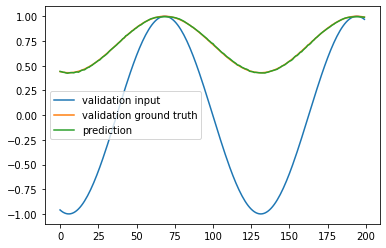

In [174]:
val_inp = np.array([val_inp_seqs[80]])
val_true = np.array([val_target_seqs[80]])
val_pred = basic_model.predict(val_inp)


plt.plot(val_inp[0], label = "validation input")
plt.plot(val_true[0], label = "validation ground truth")
plt.plot(val_pred[0], label = "prediction")
plt.legend()
plt.show()


# Basic Model - Multi dimensional

In [175]:
surrogate_quadruples

val_frac = 0.15 # amount of val; amount of test 

random.shuffle(surrogate_quadruples)
num_val_samples = int(val_frac * len(surrogate_quadruples))
num_train_samples = len(surrogate_quadruples) - 2 * num_val_samples
train_quads = surrogate_quadruples[:num_train_samples]
val_quads = surrogate_quadruples[num_train_samples : num_train_samples + num_val_samples]
test_quads = surrogate_quadruples[num_train_samples + num_val_samples :]

print(f"{len(surrogate_quadruples)} total quads")
print(f"{len(train_quads)} training quads")
print(f"{len(val_quads)} validation quads")
print(f"{len(test_quads)} test quads")






801 total quads
561 training quads
120 validation quads
120 test quads


In [176]:
X = np.array(train_quads[:,0:2,:])
X = X.reshape(X.shape[0],-1)
Y = np.array(train_quads[:,2:,:])
Y = Y.reshape(Y.shape[0],-1)

tf.keras.backend.clear_session()

basic_model_multi = keras.models.Sequential()
basic_model_multi.add(layers.Dense(400, input_dim = X.shape[1], activation='tanh')) # relu
basic_model_multi.add(layers.Dense(400, activation='tanh')) # relu
basic_model_multi.add(layers.Dense(400, activation='tanh')) # sigmoid
# compile the keras model
basic_model_multi.compile(loss="mse", optimizer='adam', metrics=['accuracy'])
basic_model_multi.summary()
# fit the keras model on the dataset
basic_model_multi.fit(X, Y, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = basic_model_multi.evaluate(X, Y)
print('Accuracy: %.2f' % (accuracy*100))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
Total params: 481,200
Trainable params: 481,200
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
57/57 [==============================] - 1s 3ms/step - loss: 0.0980 - accuracy: 0.0362
Epoch 2/150
57/57 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 0.0656
Epoch 3/150
57/57 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.0672
Epoch 4/150
57/57 [==============================] - 0s 3ms/step - loss: 8.4994e-04

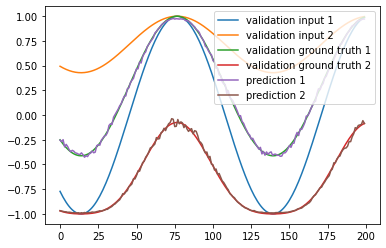

In [177]:
# use from train dataset 
if False:
    val_inp = np.array([X[200,:]])
    val_true = np.array([Y[200,:]])
# use actual validation 
else:
    val_inp = np.array(val_quads[:,0:2,:])
    val_inp = val_inp.reshape(val_inp.shape[0],-1)
    val_inp = np.array([val_inp[100,:]])
    val_true = np.array(val_quads[:,2:4,:])
    val_true = val_true.reshape(val_true.shape[0],-1)
    val_true = np.array([val_true[100,:]])
    
val_out = basic_model_multi(val_inp) # predict 
    

plt.plot(val_inp[0][0:200], label = "validation input 1")
plt.plot(val_inp[0][200:400], label = "validation input 2")
plt.plot(val_true[0][0:200], label = "validation ground truth 1")
plt.plot(val_true[0][200:400], label = "validation ground truth 2")
plt.plot(val_out[0][0:200], label = "prediction 1")
plt.plot(val_out[0][200:400], label = "prediction 2")
plt.legend()
plt.show()